## Linear Regression With Time Series Data

In [108]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

##### Preparing Data

In [109]:
#Read csv. 
df = pd.read_csv("tmp98wp4ncj.csv")


In [110]:
df.shape
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,49;pms5003;3573;-1.289;36.825;2024-03-01T00:00...
1,49;pms5003;3573;-1.289;36.825;2024-03-01T00:00...
2,49;pms5003;3573;-1.289;36.825;2024-03-01T00:00...
3,50;DHT22;3573;-1.289;36.825;2024-03-01T00:00:0...
4,50;DHT22;3573;-1.289;36.825;2024-03-01T00:00:0...


In [111]:
#Create dataframe with columns; "timestamp", "value_type", "value"
df1 = (df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"]
       .str.split(";", expand=True)
       .rename(columns={5:"timestamp",6:"value_type",7:"value"})
       .drop(columns=[0,1,2,3,4])
       )

print(df1.info())
df1.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284182 entries, 0 to 284181
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   284182 non-null  object
 1   value_type  284182 non-null  object
 2   value       284182 non-null  object
dtypes: object(3)
memory usage: 6.5+ MB
None


,timestamp,value_type,value
0,2024-03-01T00:00:05.126827+00:00,P2,9.00
1,2024-03-01T00:00:05.126827+00:00,P1,9.00
2,2024-03-01T00:00:05.126827+00:00,P0,4.60
3,2024-03-01T00:00:06.192422+00:00,humidity,99.90
4,2024-03-01T00:00:06.192422+00:00,temperature,19.40


In [112]:
#Extract "P2" readings 
df2 = df1[df1["value_type"]=="P2"]
df2.head()

,timestamp,value_type,value
0,2024-03-01T00:00:05.126827+00:00,P2,9.00
5,2024-03-01T00:00:37.356389+00:00,P2,7.40
10,2024-03-01T00:01:11.142661+00:00,P2,9.20
15,2024-03-01T00:01:24.360271+00:00,P2,15.00
20,2024-03-01T00:01:43.241826+00:00,P2,7.00


In [113]:
#Drop "value_type" column
df2.drop(columns="value_type",inplace=True)
df2.head()


C:\Users\USER\AppData\Local\Temp\ipykernel_7252\1418606537.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp,value
0,2024-03-01T00:00:05.126827+00:00,9.00
5,2024-03-01T00:00:37.356389+00:00,7.40
10,2024-03-01T00:01:11.142661+00:00,9.20
15,2024-03-01T00:01:24.360271+00:00,15.00
20,2024-03-01T00:01:43.241826+00:00,7.00


In [114]:
#Convert "value" to float, "timestamp" to datetime
df2["timestamp"] = pd.to_datetime(df2["timestamp"])
df2["value"] = df2["value"].astype(float)
df2.info()


<class 'pandas.core.frame.DataFrame'>
Index: 63687 entries, 0 to 284180
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  63687 non-null  datetime64[ns, UTC]
 1   value      63687 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 1.5 MB


C:\Users\USER\AppData\Local\Temp\ipykernel_7252\3983478762.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_7252\3983478762.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
#Set_index to "timestamp"
df3 = pd.DataFrame(df2).set_index("timestamp")
df3.head()




,value
timestamp,
2024-03-01 00:00:05.126827+00:00,9.0
2024-03-01 00:00:37.356389+00:00,7.4
2024-03-01 00:01:11.142661+00:00,9.2
2024-03-01 00:01:24.360271+00:00,15.0
2024-03-01 00:01:43.241826+00:00,7.0


In [116]:
#localize timezone to "Africa/Nairobi"
df4 = df3.tz_convert("Africa/Nairobi")
df4.head()




,value
timestamp,
2024-03-01 03:00:05.126827+03:00,9.0
2024-03-01 03:00:37.356389+03:00,7.4
2024-03-01 03:01:11.142661+03:00,9.2
2024-03-01 03:01:24.360271+03:00,15.0
2024-03-01 03:01:43.241826+03:00,7.0


##### Exploring Data

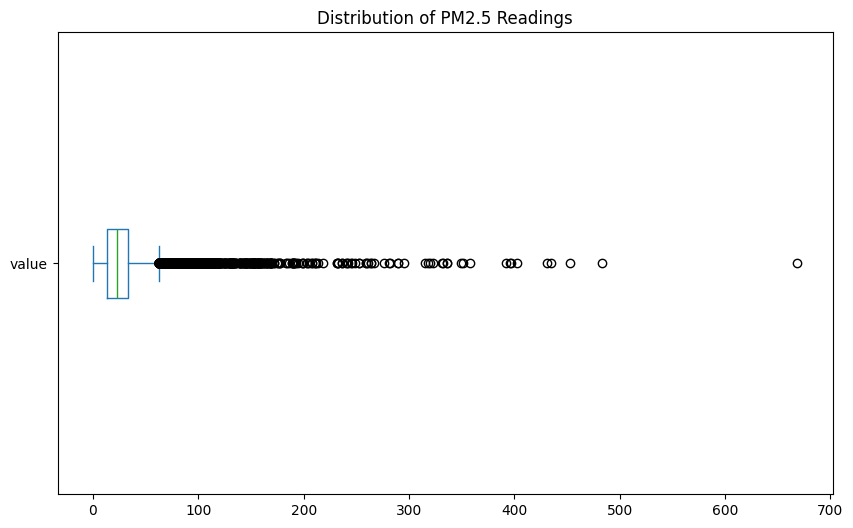

In [117]:
#Create a boxplot of "P2" readings in df4
fig, ax = plt.subplots(figsize = (10,6))
df4["value"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);


In [118]:
#Remove outliers
df5 = df4[df4["value"] <300]
df5.info()
df5.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63667 entries, 2024-03-01 03:00:05.126827+03:00 to 2024-03-19 07:30:42.060092+03:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   63667 non-null  float64
dtypes: float64(1)
memory usage: 994.8 KB


,value
timestamp,
2024-03-01 03:00:05.126827+03:00,9.0
2024-03-01 03:00:37.356389+03:00,7.4
2024-03-01 03:01:11.142661+03:00,9.2
2024-03-01 03:01:24.360271+03:00,15.0
2024-03-01 03:01:43.241826+03:00,7.0


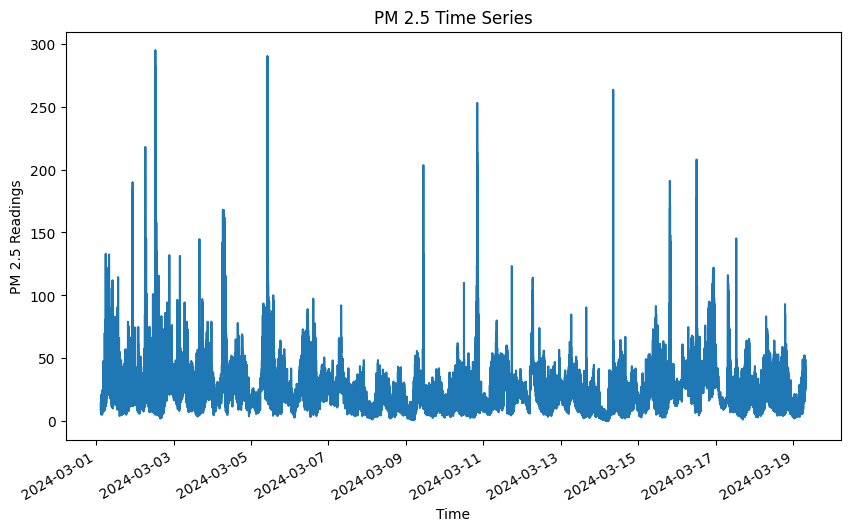

In [119]:
#Create a time series of "P2" readings and df5
fig, ax = plt.subplots(figsize = (10,6))
df5["value"].plot(xlabel="Time", ylabel="PM 2.5 Readings", title="PM 2.5 Time Series", ax=ax);

In [120]:
#Resample df5 to provide a mean "P2" readings for each hour, using forward fill to impute missing values
df6 = df5["value"].resample("1h").mean().fillna(method = "ffill").to_frame()
df6.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_7252\2325363843.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,value
timestamp,
2024-03-01 03:00:00+03:00,10.694910
2024-03-01 04:00:00+03:00,17.205427
2024-03-01 05:00:00+03:00,27.606415
2024-03-01 06:00:00+03:00,49.391576
2024-03-01 07:00:00+03:00,55.893840


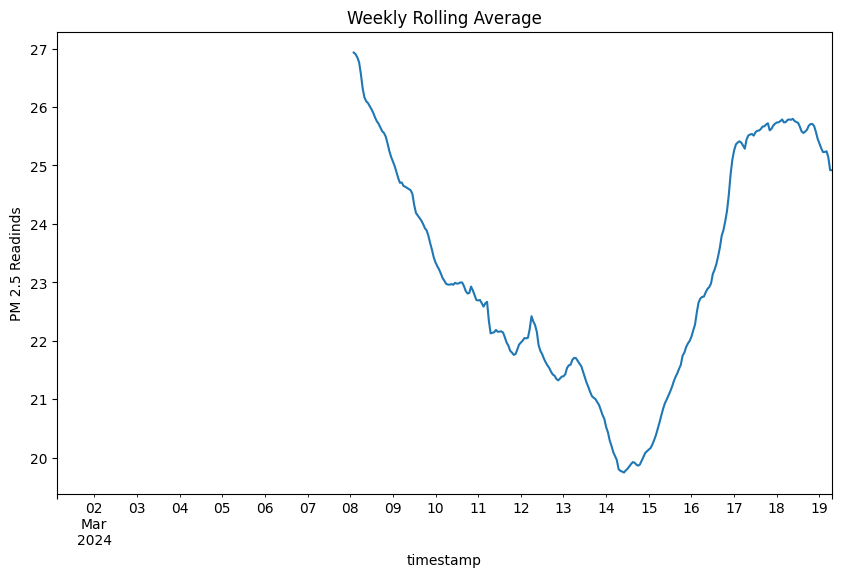

In [121]:
#Plot the rolling average of the "P2" readings in df6, use window size of 168(hours in a week)
fig, ax = plt.subplots(figsize = (10,6))
df6["value"].rolling(168).mean().plot(ylabel= "PM 2.5 Readinds", title = "Weekly Rolling Average", ax = ax );


In [122]:
#Create a lag feature "value_1"
df6["value_1"] = df6["value"].shift(1)
#Drop NaN
df6.dropna(inplace=True)
df6.head()

,value,value_1
timestamp,,
2024-03-01 04:00:00+03:00,17.205427,10.694910
2024-03-01 05:00:00+03:00,27.606415,17.205427
2024-03-01 06:00:00+03:00,49.391576,27.606415
2024-03-01 07:00:00+03:00,55.893840,49.391576
2024-03-01 08:00:00+03:00,39.637546,55.893840


In [123]:
#Create a correlation matrix for df6
df6.corr()

,value,value_1
value,1.000000,0.738268
value_1,0.738268,1.000000


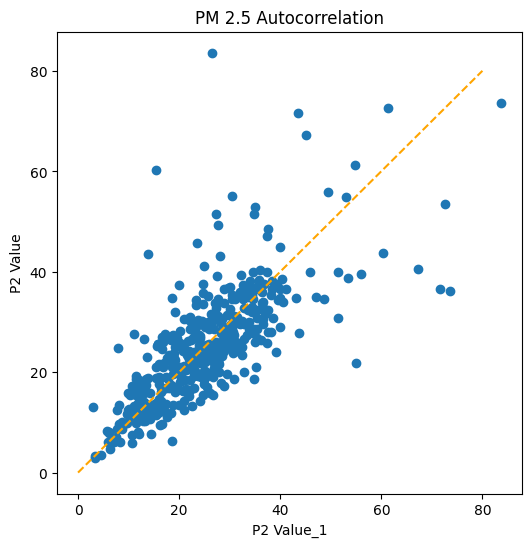

In [124]:
#Create a scatter plot that shows PM 2.5 mean reading  for each hour as a function of mean for previous hour
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x=df6["value_1"], y=df6["value"])
ax.plot([0, 80], [0, 80], linestyle = "--", color = "orange")
plt.xlabel("P2 Value_1")
plt.ylabel("P2 Value")
plt.title("PM 2.5 Autocorrelation");



##### Splitting

In [125]:
#Split df6 into matrix feature matrix X and target y
target = "value"
y = df6["value"]
X = df6.drop(columns=target)

In [126]:
X.head()
X.shape

(436, 1)

In [127]:
#Split X and y into training and tests sets, the first 80 % of the data should be training set and 20% test set
cut_off = int(len(X)*0.8)
X_train, y_train = X.iloc[:cut_off], y.iloc[:cut_off]
X_test, y_test = X.iloc[cut_off:], y.iloc[cut_off:]

##### Building Model

In [128]:
#Calculate the mean absolute error for the baseline model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 23.84
Baseline MAE: 8.18


#### Iterating

In [129]:
# Instantiate LinearRegression in the model and fit it into training data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Evaluating

In [133]:
# Calculate the training and test mean absolute error  the model
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae,2))

Training MAE: 5.01
Test MAE: 5.79


In [136]:
#Extract the intercepts and coefficients for the model
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)
print(f"value = {intercept} + {coefficient} * value_1")

value = 6.53 + [0.73] * value_1


In [138]:
#Create a df_pred_test that has "y_test" and "y_pred" 
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
        
    }
    
    
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2024-03-15 16:00:00+03:00,21.997268,23.111529
2024-03-15 17:00:00+03:00,24.158442,22.525082
2024-03-15 18:00:00+03:00,27.271742,24.096633
2024-03-15 19:00:00+03:00,51.407022,26.360546
2024-03-15 20:00:00+03:00,30.771028,43.911114


In [139]:
#Create a time series line plot for values in test_predictions
fig = px.line(df_pred_test, labels= "value:P2")
fig.show()